# LIGHT GBM

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
import lightgbm as lgb

In [2]:
labels = pd.read_csv('../../csv/train_labels.csv')
labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [3]:
values = pd.read_csv('../../csv/train_values.csv')
values.T

,0,1,2,3,4,5,6,7,8,9,...,260591,260592,260593,260594,260595,260596,260597,260598,260599,260600
building_id,802906,28830,94947,590882,201944,333020,728451,475515,441126,989500,...,560805,207683,226421,159555,827012,688636,669485,602512,151409,747594
geo_level_1_id,6,8,21,22,11,8,9,20,0,26,...,20,10,8,27,8,25,17,17,26,21
geo_level_2_id,487,900,363,418,131,558,475,323,757,886,...,368,1382,767,181,268,1335,715,51,39,9
geo_level_3_id,12198,2812,8973,10694,1488,6089,12066,12236,7219,994,...,5980,1903,8613,1537,4718,1621,2060,8163,1851,9101
count_floors_pre_eq,2,2,2,2,3,2,2,2,2,1,...,1,2,2,6,2,1,2,3,2,3
age,30,10,10,10,30,10,25,0,15,0,...,25,25,5,0,20,55,0,55,10,10
area_percentage,6,8,5,6,8,9,3,8,8,13,...,5,5,13,13,8,6,6,6,14,7
height_percentage,5,7,5,5,9,5,4,6,6,4,...,3,5,5,12,5,3,5,7,6,6
land_surface_condition,t,o,t,t,t,t,n,t,t,t,...,n,t,t,t,t,n,t,t,t,n
foundation_type,r,r,r,r,r,r,r,w,r,i,...,r,r,r,r,r,r,r,r,r,r


In [4]:
values["building_id"].count() == values["building_id"].drop_duplicates().count()

True

In [5]:
to_be_categorized = ["land_surface_condition", "foundation_type", "roof_type",\
                     "position", "ground_floor_type", "other_floor_type",\
                     "plan_configuration", "legal_ownership_status"]
for row in to_be_categorized:
    values[row] = values[row].astype("category")

In [6]:
datatypes = dict(values.dtypes)
for row in values.columns:
    if datatypes[row] != "int64" and datatypes[row] != "int32" and \
       datatypes[row] != "int16" and datatypes[row] != "int8":
        continue
    if values[row].nlargest(1).item() > 32767 and values[row].nlargest(1).item() < 2**31:
        values[row] = values[row].astype(np.int32)
    elif values[row].nlargest(1).item() > 127:
        values[row] = values[row].astype(np.int16)
    else:
        values[row] = values[row].astype(np.int8)

In [7]:
labels["building_id"] = labels["building_id"].astype(np.int32)
labels["damage_grade"] = labels["damage_grade"].astype(np.int8)

In [8]:
important_values = values\
                .merge(labels, on="building_id")
important_values.drop(columns=["building_id"], inplace = True)
important_values["geo_level_1_id"] = important_values["geo_level_1_id"].astype("category")
important_values["geo_level_2_id"] = important_values["geo_level_2_id"].astype("category")

In [9]:
X_train, X_test, y_train, y_test = train_test_split(important_values.drop(columns = 'damage_grade'),
                                                    important_values['damage_grade'], test_size = 0.2, random_state = 123)

# OneHot Encoding 


In [10]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ["geo_level_1_id", "geo_level_2_id", "land_surface_condition", "foundation_type", "roof_type",\
                     "position", "ground_floor_type", "other_floor_type",\
                     "plan_configuration", "legal_ownership_status"]
for feature in features_to_encode:
    X_train = encode_and_bind(X_train, feature)
    X_test = encode_and_bind(X_test, feature)

In [11]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', 
                         colsample_bytree=1.0,
                         importance_type='split', 
                         learning_rate=0.15,
                         max_depth=40,
                         n_estimators=1000, 
                         n_jobs=-1,
                         objective=None,
                         subsample=0.8, 
                         verbose = 1)
clf.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2758
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 1180
[LightGBM] [Info] Start training from score -2.342113
[LightGBM] [Info] Start training from score -0.563143
[LightGBM] [Info] Start training from score -1.095241


LGBMClassifier(learning_rate=0.15, max_depth=40, n_estimators=1000,
               subsample=0.8, verbose=1)

In [12]:
clf_pred = clf.predict(X_test)
f1_score(y_test, clf_pred, average='micro')

0.7438268644116575

In [29]:
len(clf.feature_importances_)

1511

<AxesSubplot:xlabel='column'>

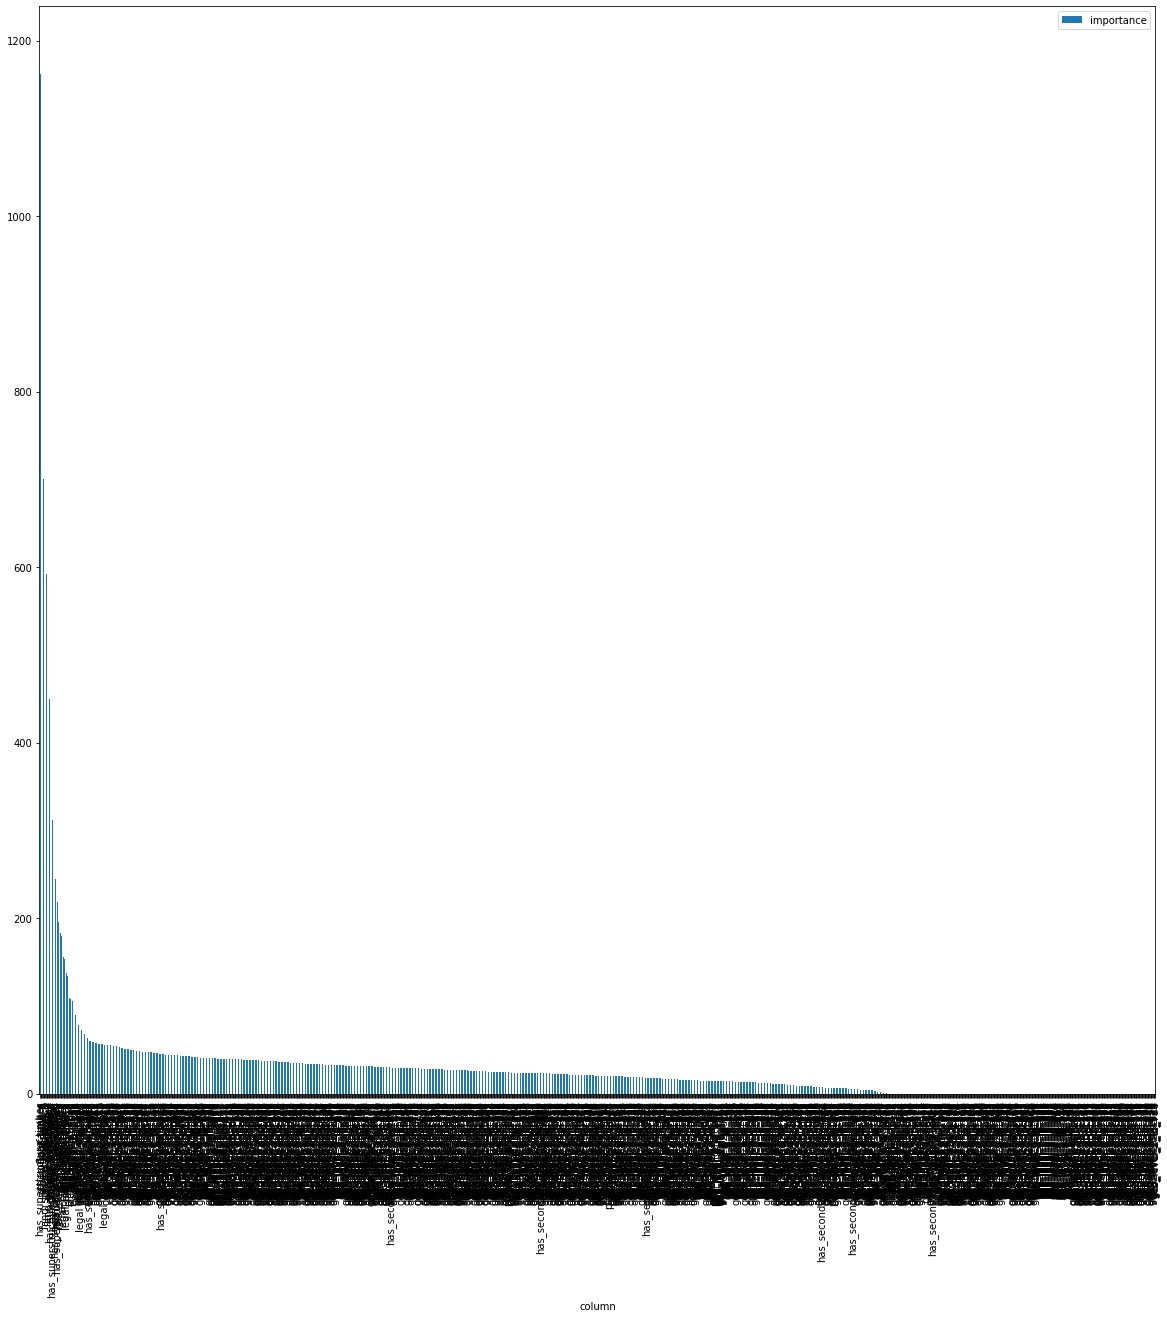

In [26]:
df = pd.DataFrame({"column": X_train.columns.to_list()[-375:], "importance": clf.feature_importances_[-1500:]})
df = df.sort_values("importance", ascending=False).set_index("column")
df.plot(kind='bar', figsize = (20,20), orientation='vertical')

### Puedo sacar el ultimo cuarto de los features menos importantes.

In [33]:
less_important_features = df.index.to_list()[-375:]
X_train.drop(columns = less_important_features, inplace = True)
X_test.drop(columns = less_important_features, inplace = True)

### Y volver a entrenar el modelo.

In [34]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', 
                         colsample_bytree=1.0,
                         importance_type='split', 
                         learning_rate=0.15,
                         max_depth=40,
                         n_estimators=1000, 
                         n_jobs=-1,
                         objective=None,
                         subsample=0.8, 
                         verbose = 1)
clf.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2670
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 1136
[LightGBM] [Info] Start training from score -2.342113
[LightGBM] [Info] Start training from score -0.563143
[LightGBM] [Info] Start training from score -1.095241


LGBMClassifier(learning_rate=0.15, max_depth=40, n_estimators=1000,
               subsample=0.8, verbose=1)

In [35]:
clf_pred = clf.predict(X_test)
f1_score(y_test, clf_pred, average='micro')

0.7433663974213849

In [39]:
less_important_features = df.index.to_list()[-640:-376]
X_train.drop(columns = less_important_features, inplace = True)
X_test.drop(columns = less_important_features, inplace = True)

In [40]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', 
                         colsample_bytree=1.0,
                         importance_type='split', 
                         learning_rate=0.15,
                         max_depth=40,
                         n_estimators=1000, 
                         n_jobs=-1,
                         objective=None,
                         subsample=0.8, 
                         verbose = 1)
clf.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2142
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 872
[LightGBM] [Info] Start training from score -2.342113
[LightGBM] [Info] Start training from score -0.563143
[LightGBM] [Info] Start training from score -1.095241


LGBMClassifier(learning_rate=0.15, max_depth=40, n_estimators=1000,
               subsample=0.8, verbose=1)

In [41]:
clf_pred = clf.predict(X_test)
f1_score(y_test, clf_pred, average='micro')

0.7435198864181424

In [42]:
less_important_features = df.index.to_list()[-850:-641]
X_train.drop(columns = less_important_features, inplace = True)
X_test.drop(columns = less_important_features, inplace = True)

In [43]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', 
                         colsample_bytree=1.0,
                         importance_type='split', 
                         learning_rate=0.15,
                         max_depth=40,
                         n_estimators=1000, 
                         n_jobs=-1,
                         objective=None,
                         subsample=0.8, 
                         verbose = 1)
clf.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 663
[LightGBM] [Info] Start training from score -2.342113
[LightGBM] [Info] Start training from score -0.563143
[LightGBM] [Info] Start training from score -1.095241


LGBMClassifier(learning_rate=0.15, max_depth=40, n_estimators=1000,
               subsample=0.8, verbose=1)

In [44]:
clf_pred = clf.predict(X_test)
f1_score(y_test, clf_pred, average='micro')

0.7417355768308359

In [15]:
test_values = pd.read_csv('../../csv/test_values.csv', index_col = "building_id")


In [16]:
test_values_subset = test_values
test_values_subset["geo_level_1_id"] = test_values_subset["geo_level_1_id"].astype("category")

In [17]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ["geo_level_1_id", "land_surface_condition", "foundation_type", "roof_type",\
                     "position", "ground_floor_type", "other_floor_type",\
                     "plan_configuration", "legal_ownership_status"]
for feature in features_to_encode:
    test_values_subset = encode_and_bind(test_values_subset, feature)


In [18]:
preds = clf.predict(test_values_subset)

In [19]:
submission_format = pd.read_csv('../../csv/submission_format.csv', index_col = "building_id")

In [20]:
my_submission = pd.DataFrame(data=df,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [19]:
df.to_csv('../../csv/predictions/LightGBM.csv')